In [210]:
from Bio import SeqIO
import numpy as np
from scipy.stats import entropy
import matplotlib.pylab as plt
from sklearn import metrics
from tqdm.notebook import trange
from joblib import Parallel, delayed

In [43]:
names = []
seqs = []
lengths = []
uniques = []
for seq_record in SeqIO.parse("data/combined-MSA.fasta", "fasta"):
    names.append(seq_record.id)
    seqs.append(str(seq_record.seq))
    uniques.append(list(set(str(seq_record.seq))))
    lengths.append(len(seq_record))

In [33]:
ls = []
for i in uniques:
    ls.append(len(i))
    
print(min(ls), max(ls))

5 5


In [40]:
max(lengths)

30865

In [67]:
array = np.array([list(word) for word in seqs]).T

In [91]:
probabilities = []
for i in range(array.shape[0]):
    uniques, counts = np.unique(array[i], return_counts=True)
    d = {u : c for u, c in zip(uniques, counts)}
    d.pop("-", None)
    s = sum(d.values())
    p = []
    for key, value in d.items():
        p.append(value / s)
    probabilities.append(p)

In [203]:
entropies = np.array([entropy(prob, base=2) for prob in probabilities])
# msk = np.argwhere(entropies > 0)
# msk = np.reshape(msk, (msk.shape[0],))

n = 500

idx = np.argpartition(entropies, -n)[-n:]
msk = idx[np.argsort((-entropies)[idx])]

entropies = np.reshape(entropies[msk], (entropies[msk].shape[0],))
msk[10]

29736

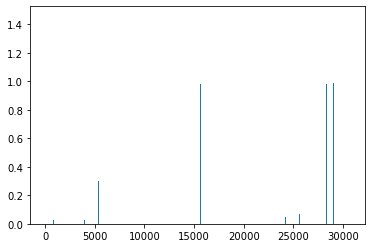

In [186]:
plt.bar(msk, entropies)
plt.savefig('barplot.pdf')
plt.show()

In [230]:
def mutualinfo_vect(array, length, i):
    res = np.zeros(shape=(length))
    for j in range(i, length):
        res[j] = metrics.mutual_info_score(array[i], array[j])
    return res

In [ ]:
length = array.shape[0]

mutual_info = Parallel(n_jobs=16)(delayed(mutualinfo_vect)(array, length, i) for i in trange(length))

mutual_info = np.stack(mutual_info)

np.save('data/mutual_info.npy', mutual_info)

  0%|          | 0/30865 [00:00<?, ?it/s]